In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import mlflow
import mlflow.sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV, KFold
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, auc, roc_auc_score
from sklearn import metrics
import matplotlib.pyplot as plt
import joblib
import os, sys
import glob
import json

# Initialise experiment and read data

In [2]:
orig_path = sys.path[0]
print(f'Running in {os.getcwd()}')
 
with open('config_ML.json', 'rb') as f:
    config = json.load(f)
 
data_dir_in = config['data_folder_in']
data_dir_out = config['data_folder_out']
ref_data_dir = config['ref_data_folder']
 
print(f'Reading data from {data_dir_in}')

Running in /mnt/batch/tasks/shared/LS_root/mounts/clusters/aml-scoring-vm5/code/Users/0szeng/gitrepos/AzureMachineLearning/LifeCycle/Scripts
Reading data from /home/azureuser/mycode/gitrepos/AzureMachineLearning/LifeCycle/Scripts/outcome_script_input


Replace below block with above --- sz

In [5]:
# orig_path = sys.path[0]
# #os.chdir('../../arriba_sandbox/upfront_risk') # need this in case we're running in thd arriba_dev folder but we still want to access the models and artefacts in prod
# config_path = f'{orig_path}/../config.json' # if we're running in dev we want the config from the dev folder
# print(f'Running in {os.getcwd()}')

# with open(config_path, 'rb') as f:
#     config = json.load(f)
# data_dir_in = config['data_folder_in']
# print(f'Reading data from {data_dir_in}')

In [3]:
# Initialise experiment and parameters

exp = mlflow.set_experiment('Lifecycle Numerical Prediction')
#mlflow.sklearn.autolog()

group = 'all' # Select which group of businesses we're using (wc, military, other, all)

predictor = 'cost_log' # Select which variable are we predicting: days, days_log, cost, cost_log
if predictor == 'days_log':
    model_selected = 'SVM' # Select model type: LinearRegression, RF, SVM, SVM_POLY, SVM_LIN
else:
    model_selected = 'RF'
n_splits = 10
n_estimators = 100
log_mult = 10

milestone = 'wk12' # wk2 | wk4 | wk6 | wk8 | wk12 | wk16 | wk20
effort_type = 'total_cost' # total_cost | total_duration | n_activities | activity_score10
use_effort=True
by_type = False
zero_effort = 'included' # included | excluded
travel_excluded = False
reporting_excluded = travel_excluded
min_upfront_score=0
max_upfront_score=1
min_claim_total_cost=0
min_hourly_pctg=0.9
n_months = 18 # number of months to use in historical data; set to 0 to use the fixed starting date 1/1/2020
out_pct = 0.85 # percentile used to filter outliers in the outcome variable; set to 1 to not filter by outliers 

In [4]:
# Read data
# claims = pd.read_csv(f'{data_dir_in}/claim_rollup.csv') ---- comment out --- sz
claims = pd.read_csv(f'/home/azureuser/mycode/gitrepos/AzureMachineLearning/LifeCycle/Scripts/dataprep_input/claim_rollup.csv',header=1)
print(f'Read {len(claims)} rows from claim_rollup')

if travel_excluded:
    milestones = pd.read_csv(f'{data_dir_in}/milestones_ex_travel.csv')
else:
    milestones = pd.read_csv(f'{data_dir_in}/milestones.csv')
print(f'Read {len(milestones)} rows from milestones')

data0 = claims.merge(milestones, on='ClaimNo', how='left')
print(f'Merged dataset contains {len(data0)} rows')

assert(len(data0)==len(data0['ClaimNo'].unique()))

##### below comment out if no up-front scores available -- sz

# Load upfront scores
# upfront_scores = pd.read_csv(f'{data_dir_in}/prob_vs_actual.csv')
# upfront_scores = upfront_scores[['ClaimNo', 'prob']].rename(columns={'prob':'uprfont_score'})
# print(f'Read {len(upfront_scores)} rows from upfront_scores')

# data0 = data0.merge(upfront_scores, on='ClaimNo', how='left')
# print(f'Merged dataset contains {len(data0)} rows')

# assert(len(data0)==len(data0['ClaimNo'].unique()))

# Load claim totals
claim_totals = pd.read_csv(f'{data_dir_in}/claim_cost_totals.csv')
print(f'Read {len(claim_totals)} rows from claim_totals')
data0 = data0.merge(claim_totals, on='ClaimNo', how='left')
print(f'Merged dataset contains {len(data0)} rows')

assert(len(data0)==len(data0['ClaimNo'].unique()))

Read 47341 rows from claim_rollup
Read 28422 rows from milestones
Merged dataset contains 47341 rows
Read 28521 rows from claim_totals
Merged dataset contains 47341 rows


In [5]:
# Delete existing files in certain directories as they contain content from previous runs
files = glob.glob('encoders/*')
for file in files:
    print(f'Deleting {file}')
    os.remove(file)

files = glob.glob('output/*')
for file in files:
    print(f'Deleting {file}')
    os.remove(file)

Deleting encoders/cat_encoder.joblib
Deleting encoders/input_vars_cat.txt
Deleting encoders/input_vars_num.txt
Deleting encoders/num_encoder.joblib
Deleting output/feature_importance.csv
Deleting output/feature_importance.png
Deleting output/input_vars_cat.txt
Deleting output/input_vars_num.txt
Deleting output/prob_vs_actual.csv


# Filter data

In [6]:
# Keep only closed claims
data0 = data0[data0['DateClosedLast'].notnull()]
print(f'Reduced dataset to {len(data0)} rows')

Reduced dataset to 42996 rows


In [7]:
# Exclude assessment-only claims
data0 = data0[data0['has_non_assessment']]
print(f'Reduced dataset to {len(data0)} rows')

Reduced dataset to 33894 rows


In [8]:
# Filter by referral date of the first case
if n_months>0:
    today = datetime.today()    
    data0 = data0[pd.to_datetime(data0['DateOfReferralFirst']) >= today - pd.DateOffset(months=n_months)]    
else:
    data0=data0[data0['DateOfReferralFirst']>='2020-01-01']

print(f'Earliest referral date is {data0.DateOfReferralFirst.min()}')
print(f'Reduced dataset to {len(data0)} rows')

Earliest referral date is 2024-02-12
Reduced dataset to 4491 rows


In [9]:
# Remove Health & Wellbeing as it's not a RTW service
data0 = data0[data0['Business_last']!='Health & Wellbeing']
print(f'Reduced dataset to {len(data0)} rows')

Reduced dataset to 4491 rows


In [10]:
# Remove claims that are closed before the milestone is reached
total_milestone_col = f'{effort_type}_{milestone}'
data0 = data0[data0[total_milestone_col]>-1]
print(f'Reduced dataset to {len(data0)} rows')    

Reduced dataset to 3262 rows


In [11]:
# Exclude claims with zero effort (rationale being that it's likely to be an error as wouldn't expect no effort at all)
if zero_effort=='excluded':
    data0 = data0[data0[total_milestone_col]>0]
    data0 = data0[data0[total_milestone_col].notnull()]
    print(f'Reduced dataset to {len(data0)} rows')    

In [12]:
# Exclude to claims with a high upfront score
# if min_upfront_score>0:
if min_upfront_score > 0 and 'uprfont_score' in data0.columns: # ensure upfront_score field exists for first run -- sz
    data0 = data0[data0['uprfont_score']>=min_upfront_score]
    print(f'Reduced dataset to {len(data0)} rows')    

In [13]:
# Exclude to claims with a low upfront score
# if max_upfront_score<1:
if max_upfront_score < 1 and 'uprfont_score' in data0.columns: # ensure upfront_score field exists for first run -- sz
    data0 = data0[data0['uprfont_score']<=max_upfront_score]
    print(f'Reduced dataset to {len(data0)} rows')   

In [14]:
# Exclude claims with a low total cost
if min_claim_total_cost>0:
    data0 = data0[data0['claim_total_cost']>=min_claim_total_cost]
    print(f'Reduced dataset to {len(data0)} rows')   

In [15]:
# Exclude claims with a low hourly-rate cost %
if min_hourly_pctg>0:
    data0 = data0[data0['claim_cost_hourly_pctg']>=min_hourly_pctg]
    print(f'Reduced dataset to {len(data0)} rows')   

Reduced dataset to 2434 rows


In [16]:
# Create DF by business group
data_wc = data0[data0['Business_last'].isin(['Workers Compensation - State Based', 'Commonwealth/Federal Employers'])].reset_index(drop=True)
data_military = data0[data0['Business_last']=='Military'].reset_index(drop=True)
data_other = data0[~data0['Business_last'].isin(['Military', 'Workers Compensation - State Based', 'Commonwealth/Federal Employers'])].reset_index(drop=True)
data_all = data0[~data0['Business_last'].isin(['Military'])].reset_index(drop=True)

In [17]:
# Set the final  dataset based on business group
if group=='wc':
    data = data_wc
elif group=='military':
    data = data_military
elif group=='other':
    data = data_other
else:
    data = data_all

print(f'Reduced to {len(data)} rows')
data['Business_last'].value_counts()

Reduced to 2143 rows


Workers Comp          1846
CTP                    176
Federal Government      74
Life Insurance          47
Name: Business_last, dtype: int64

In [18]:
# Filter out the claims whose duration is an extreme outlier
if 'days' in predictor:
    data = data[data['rtw_days_max']<data['rtw_days_max'].quantile(out_pct)]
    print(f'Highest RTW value is {data.rtw_days_max.max()}')
    print(f'Reduced to {len(data)} rows')
else:
    data = data[data['CostsTotalExTax']<data['CostsTotalExTax'].quantile(out_pct)]
    print(f'Highest cost value is {data.CostsTotalExTax.max()}')
    print(f'Reduced to {len(data)} rows')

Highest cost value is 11298.32
Reduced to 1821 rows


In [19]:
# Filtering completed, reset index
data.reset_index(drop=True, inplace=True)

# Select variables to use

In [20]:
# Input vars

input_cols_cat = [
    #'Cause'
    #'Condition'
    'Gender'
    #, 'OfficeState_last'
    #, 'CategoryGroupLast'
    #, 'req_type_last'
    , 'Business_last'
    , 'Region_last'
    #, 'agent_qual_grp_last'
    , 'State'
    , 'capacity_first_notnull'
    , 'capacity_type_first_notnull'
    , 'industry_first_notnull', 'injury_type_first_notnull'
    , 'injury_group_first_notnull'
    ]
input_cols_num = [
    'days_to_first_referral',
    'capacity_weight_first_notnull',
    'age', 'postcode_income_weekly_last', 'Remoteness_last'
    #, 'jotform_lowest_score_min', 'JotForm_highest_score_max'
    , 'injury_first_notnull'
    , 'injury_number_first_notnull'
    , 'Industry_physicality_first_notnull'
    ]

if use_effort:
    if by_type:
        for col in list(data.columns):
            if milestone in col and effort_type in col and col!=f'{effort_type}_{milestone}':
                if milestone!='wk2' or '20' not in col: # Ensure that when we select wk2 it doesn't match with wk20                
                    input_cols_num.append(col)
                    data[col].fillna(0, inplace=True)
    else:
        data[total_milestone_col].fillna(0, inplace=True)
        input_cols_num.append(total_milestone_col)

if group=='military':
    input_cols_num = list(set(input_cols_num) - set(['days_to_first_referral', 'capacity_weight_first_notnull']))
    input_cols_cat = list(set(input_cols_cat) - set(['capacity_first_notnull', 'capacity_type_first_notnull']))

inputs = data[input_cols_cat + input_cols_num]

/tmp/ipykernel_14689/2460842006.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[total_milestone_col].fillna(0, inplace=True)


In [21]:
input_cols_num

['days_to_first_referral',
 'capacity_weight_first_notnull',
 'age',
 'postcode_income_weekly_last',
 'Remoteness_last',
 'injury_first_notnull',
 'injury_number_first_notnull',
 'Industry_physicality_first_notnull',
 'total_cost_wk12']

In [22]:
# For injury, grab the number from the start of the string
inputs['injury_first_notnull'] = inputs['injury_first_notnull'].apply(lambda x: np.nan if pd.isnull(x) else int(x[0:2]))

/tmp/ipykernel_14689/2764389954.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inputs['injury_first_notnull'] = inputs['injury_first_notnull'].apply(lambda x: np.nan if pd.isnull(x) else int(x[0:2]))


In [23]:
# Save selected variables to file for tracking purposes
pd.DataFrame(input_cols_cat).to_csv('output/input_vars_cat.txt', header=False, sep=',', index=False)
pd.DataFrame(input_cols_num).to_csv('output/input_vars_num.txt', header=False, sep=',', index=False)

# Encode categorical vars

In [25]:
# One-hot encoder
inputs[input_cols_cat] = inputs[input_cols_cat].fillna('Unknown')
# catEncoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
catEncoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
cat_enc = catEncoder.fit(inputs[input_cols_cat])
joblib.dump(cat_enc, 'encoders/cat_encoder.joblib')
pd.DataFrame(input_cols_cat).to_csv('encoders/input_vars_cat.txt', header=False, sep=',', index=False)

transformed_matrix = cat_enc.transform(inputs[input_cols_cat])
df_cat = pd.DataFrame(transformed_matrix, columns=cat_enc.get_feature_names_out(input_cols_cat), index=data.index).astype('int')

/tmp/ipykernel_14689/219461687.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inputs[input_cols_cat] = inputs[input_cols_cat].fillna('Unknown')


# Encode numerical vars

In [26]:
# Handle outliers
if group!='military' and 'days_to_first_referral' in list(inputs.columns):
    inputs['days_to_first_referral'] = inputs['days_to_first_referral'].apply(lambda x: x if 0<=x<=1000 else np.nan)

/tmp/ipykernel_14689/591488982.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inputs['days_to_first_referral'] = inputs['days_to_first_referral'].apply(lambda x: x if 0<=x<=1000 else np.nan)


In [27]:
if False: # for unit-testing
    inputs_temp = pd.concat([data[['ClaimNo']], inputs], axis=1)
    inputs_temp.to_csv('test/input_cols_num_training.csv')
    inputs_temp.head(5)

In [28]:
# Encode
scalarEncoder = StandardScaler() 
num_enc = scalarEncoder.fit(inputs[input_cols_num])
joblib.dump(num_enc, 'encoders/num_encoder.joblib')
pd.DataFrame(input_cols_num).to_csv('encoders/input_vars_num.txt', header=False, sep=',', index=False)

inputs_scaled = num_enc.transform(inputs[input_cols_num])
df_num = pd.DataFrame(inputs_scaled, columns = input_cols_num, index=data.index)
df_num.fillna(0, inplace=True) # The scaled mean is 0
df_num.describe()

,days_to_first_referral,capacity_weight_first_notnull,age,postcode_income_weekly_last,Remoteness_last,injury_first_notnull,injury_number_first_notnull,Industry_physicality_first_notnull,total_cost_wk12
count,1.821000e+03,1.821000e+03,1.821000e+03,1.821000e+03,1.821000e+03,1.821000e+03,1.821000e+03,1.821000e+03,1.821000e+03
mean,4.682324e-17,2.341162e-17,1.794891e-16,2.263123e-16,7.803874e-17,6.633293e-17,6.633293e-17,-3.121550e-17,7.803874e-18
std,9.811408e-01,9.724219e-01,9.411239e-01,9.839369e-01,9.844952e-01,9.828194e-01,7.969723e-01,9.870035e-01,1.000275e+00
min,-6.331916e-01,-9.395392e-01,-3.259436e+00,-1.724857e+00,-7.191123e-01,-2.394793e+00,-2.049790e+00,-1.895458e+00,-2.422514e+00
25%,-5.147923e-01,-9.395392e-01,-6.464840e-01,-7.714209e-01,-7.191123e-01,-7.353126e-01,-7.909179e-01,-3.609160e-01,-7.092601e-01
50%,-3.839299e-01,0.000000e+00,0.000000e+00,-1.926289e-01,-7.191123e-01,-7.152063e-02,0.000000e+00,-3.609160e-01,-1.069443e-01
75%,0.000000e+00,1.023569e+00,7.325738e-01,6.217180e-01,5.136517e-01,7.582194e-01,1.082767e-01,1.173626e+00,6.426043e-01
max,5.542267e+00,1.677939e+00,3.272943e+00,4.258237e+00,4.211944e+00,1.975171e+00,1.726827e+00,1.173626e+00,3.466796e+00


# Set up model

count     1821.000000
mean      4806.065272
std       2268.528675
min        242.500000
25%       2946.100000
50%       4505.300000
75%       6410.930000
max      10710.800000
dtype: float64
count    1821.000000
mean       10.653031
std         0.534647
min         7.793587
25%        10.290823
50%        10.715595
75%        11.068345
max        11.581593
dtype: float64


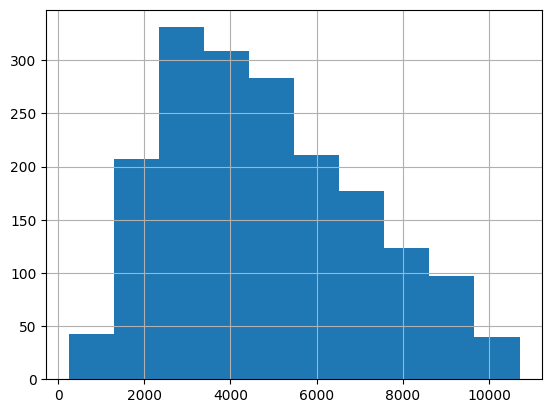

In [29]:
# Outcome var
if 'days' in predictor:
    y = data['rtw_days_max'] - 7*int(milestone[2:]) # this is the number of days that are left over, ie from the milestone to the end.
    
elif 'cost' in predictor:
    y = data['CostsTotalExTax'] - data[total_milestone_col] # this is the cost that is left over, ie from the milestone to the end.
    
y = y.apply(lambda x: 0 if x<0 else x)

print(y.describe())
y.hist()

if 'log' in predictor:
    y_median = y.median()
    y = y.apply(lambda x: y_median if x<=0 else x)
    y_log = np.log(log_mult*y)
    print(y_log.describe())


In [30]:
# Inputs
X = pd.concat([df_cat, df_num], axis=1)

In [31]:
# Model and CV setting
if model_selected=='LinearRegression':
    model = LinearRegression()
elif model_selected=='SVM_RBF':
    model = svm.SVC(kernel='rbf')
elif model_selected=='SVM':
    model = svm.SVR()
elif model_selected=='SVM_POLY':
    model = svm.SVR(kernel='poly')
elif model_selected=='SVM_LIN':
    model = svm.SVR(kernel='linear')
elif model_selected=='RF':
    model = RandomForestRegressor(n_estimators=n_estimators)

skf = KFold(n_splits=n_splits, shuffle=True)

print(model)

RandomForestRegressor()


# Start MLFlow run

Size of entire dataset: 1821


           mae           mse        r2
0  1615.846100  4.526440e+06  0.147531
1  1513.671151  3.529905e+06  0.280247
2  1616.770544  4.438721e+06  0.141677
3  1561.594261  4.047404e+06  0.221764
4  1621.552676  4.866382e+06  0.134167
5  1713.417005  4.832558e+06  0.038394
6  1525.617829  3.744567e+06  0.188207
7  1488.459095  4.026564e+06  0.270664
8  1433.050626  3.417785e+06  0.242626
9  1576.746418  4.369242e+06  0.197324


mae    1.566673e+03
mse    4.179957e+06
r2     1.862601e-01
dtype: float64


2025/08/11 00:33:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run mango_car_2vp0t2yz at: https://35239ab7-0be2-40d7-96e6-d38aa06a8005.workspace.australiaeast.api.azureml.ms/mlflow/v2.0/subscriptions/24fceea3-b944-4568-9028-d77c36beaab5/resourceGroups/rg-machinelearning-prod-ae-001/providers/Microsoft.MachineLearningServices/workspaces/arriba-mlworkspace-prod-ae-001/#/experiments/a09bb485-655e-45d5-8527-a7aa0c883dc8/runs/2239417f-5cd9-4d2e-8b0b-6ca6252fe019
🧪 View experiment at: https://35239ab7-0be2-40d7-96e6-d38aa06a8005.workspace.australiaeast.api.azureml.ms/mlflow/v2.0/subscriptions/24fceea3-b944-4568-9028-d77c36beaab5/resourceGroups/rg-machinelearning-prod-ae-001/providers/Microsoft.MachineLearningServices/workspaces/arriba-mlworkspace-prod-ae-001/#/experiments/a09bb485-655e-45d5-8527-a7aa0c883dc8


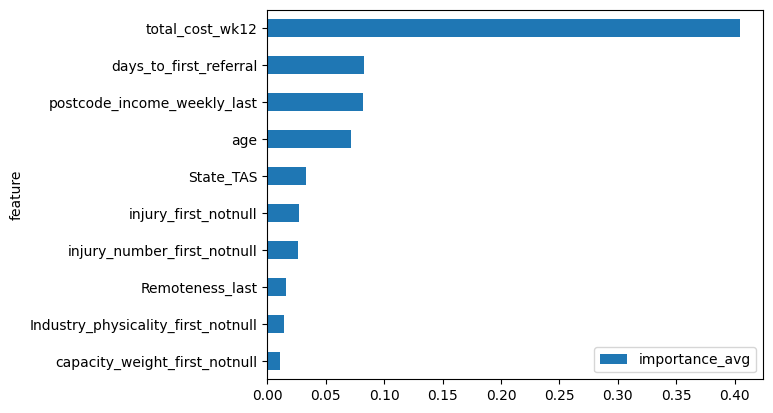

In [32]:
with mlflow.start_run():
    mlflow.set_tag('bus_group', group)
    mlflow.set_tag('predictor', predictor)
    mlflow.set_tag('model', model_selected)
    mlflow.set_tag('milestone', milestone)
    mlflow.set_tag('zero_effort', zero_effort)
    mlflow.set_tag('travel_excluded', travel_excluded)
    mlflow.set_tag('reporting_excluded', reporting_excluded)
    mlflow.set_tag('by_type', by_type)
    mlflow.set_tag('effort_type', effort_type)
    mlflow.set_tag('use_effort', use_effort)
    mlflow.log_param('n_splits', n_splits)
    mlflow.log_param('n_estimators', n_estimators)
    mlflow.log_param('log_mult', log_mult)    
    mlflow.log_param('min_upfront_score', min_upfront_score)
    mlflow.log_param('max_upfront_score', max_upfront_score)
    mlflow.log_param('min_claim_total_cost', min_claim_total_cost)
    mlflow.log_param('min_hourly_pctg', min_hourly_pctg)
    mlflow.log_param('n_months', n_months) 
    mlflow.log_param('out_pct', out_pct)     
    
    scores=[]
    prob_vs_actual_list=[]
    feature_importances=[]

    for train, test in skf.split(X, y):
        if 'log' in predictor:            
            model.fit(X.iloc[train], y_log.iloc[train])            
            y_pred_log = model.predict(X.iloc[test])
            y_pred = np.exp(y_pred_log)/log_mult
        else:
            model.fit(X.iloc[train], y.iloc[train])            
            y_pred = model.predict(X.iloc[test])

        y_test = y.iloc[test]

        mae = metrics.mean_absolute_error(y_test, y_pred)
        mse = metrics.mean_squared_error(y_test, y_pred)
        r2 = metrics.r2_score(y_test, y_pred)
        scores.append({'mae': mae, 'mse': mse, 'r2':r2})

        prob_vs_actual = pd.concat([pd.DataFrame(y_pred, columns=['predicted'], index=test), y.iloc[test]], axis=1)
        prob_vs_actual_list.append(prob_vs_actual)      

        if 'SVM' not in model_selected:
            feature_importances.append(model.feature_importances_)


    scores_df=pd.DataFrame(scores)

    print(f'Size of entire dataset: {len(X)}')
    print('\n')
    print(scores_df)
    print('\n')
    print(scores_df.mean())

    if True:
        mlflow.log_metrics({
            'r2_avg':scores_df['r2'].mean(),
            'r2_std':scores_df['r2'].std(),
            'mae_avg':scores_df['mae'].mean(),
            'mae_std':scores_df['mae'].std(),
            'mse_avg':scores_df['mse'].mean(),
            'mse_std':scores_df['mse'].std()            
            })

    # Feature importance
    if True and 'SVM' not in model_selected:
        feature_importance_df = pd.DataFrame(feature_importances, columns=X.columns)
        feat_imp_summ = pd.concat([pd.DataFrame(feature_importance_df.mean(),  columns=['importance_avg']), pd.DataFrame(feature_importance_df.std(),  columns=['importance_std'])], axis=1)
        feat_imp_summ['feature'] = feat_imp_summ.index
        feat_imp_summ.sort_values('importance_avg', ascending=False)
        feat_imp_summ.reset_index(drop=True, inplace=True)
        feat_imp_summ.to_csv('output/feature_importance.csv')

        feat_imp_summ = feat_imp_summ.sort_values('importance_avg', ascending=True)
        feat_imp_summ = feat_imp_summ[feat_imp_summ['importance_avg']>0.01]
        fig = feat_imp_summ.plot.barh(x='feature', y='importance_avg')
        fig.figure.savefig("output/feature_importance.png", bbox_inches='tight')

    # Prob vs actual
    if True:
        prob_vs_actual_all = pd.concat(prob_vs_actual_list)
        prob_vs_actual_all = prob_vs_actual_all.merge(data[['ClaimNo']], left_index=True, right_index=True)
        prob_vs_actual_all.rename(columns={prob_vs_actual_all.columns[1]: 'actual'}, inplace=True)
        prob_vs_actual_all.to_csv('output/prob_vs_actual.csv')

        prob_vs_actual_all['diff_abs'] = abs(prob_vs_actual_all['predicted'] - prob_vs_actual_all['actual'])        
        mlflow.log_metrics({'med_abs_diff':prob_vs_actual_all['diff_abs'].median()})

    # Set up indexing parameter
    if out_pct<1:
        indexing_param = prob_vs_actual_all['predicted'].max()
    else:
        indexing_param = prob_vs_actual_all['predicted'].quantile(0.95)
    with open("encoders/indexing_param.txt", "w") as text_file:
        text_file.write(str(indexing_param))

    mlflow.log_artifact('output')
    mlflow.log_artifact('encoders')
    mlflow.sklearn.log_model(model, 'models')
    mlflow.end_run()

# End